In [1]:
import pickle
import gzip
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_mldata
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('ggplot')

/Users/TenzinNorden/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/TenzinNorden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# MNIST Dataset

In [2]:
#import mnist pickled file 
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')

#assign mnist data to training, validation and test
#784 features and 70000 samples
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

#training data and target
X_train = np.array(training_data[0])
Y_train = np.array(training_data[1])

#validation set
X_val   = np.array(validation_data[0])
Y_val   = np.array(validation_data[1])

#testing set
X_test  = np.array(test_data[0])
Y_test  = np.array(test_data[1])

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)
(10000, 784)
(10000,)


# USPS Dataset

In [3]:
from PIL import Image
import os
import numpy as np

#Get USPS dataset
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

#get each image and process it. 
for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)
            
#Usps dataset
USPS_x = np.array(USPSMat)
USPS_y = np.array(USPSTar)

print(USPS_x.shape)
print(USPS_y.shape)

(19999, 784)
(19999,)


## define confusion matrix and plot it

In [106]:
# confusion matrix 
def confusion_matrix(prediction, target):
    y_actu = pd.Series(target, name='Actual %')  #actual target vector
    y_pred = pd.Series(prediction, name='Predicted %')  # predicted value
    df_confusion = pd.crosstab(y_actu, y_pred)  # make a cross table -> confusion matrix
    #return normalized confusion matrix in percentage
    return np.around(df_confusion/df_confusion.sum(axis=1), 3)*100 # make it percentage

# plot confusion matrix
def plot_confMat(matrix, title, filename):
    #seaborn
    sn.set(font_scale=1.4)#for label size
    #plot heatmap
    sns_plot = sn.heatmap(matrix, annot=True, cmap="BuPu", annot_kws={"size": 13}).set_title(title)
    #sn.title(title)
    plt.show()
    #save confusion matrix figure
    sns_plot.figure.savefig(filename + '.png')

# Model 1. Softmax Regression (Multiclass Logistic Regression)

In [107]:
# define softmax function
def softmax(x):
    e = np.exp(x - np.max(x))  # - np.max(x) to prevent overflow
    ex = np.exp(x)
#     if e.ndim == 1:
#         return e / np.sum(e, axis=0)
#     else:  
    return e / np.array([np.sum(e, axis=1)]).T

#generate prediction probalities for each digits from 0 to 9. 
def OutputValue(X, W):
    Op = np.dot(X, W)
    
    # generate probability of the occurance of each output. # all values in a set should sum up to 1(softmax)
    probability = softmax(Op)
    return probability

#define loss function for softmax
def cross_entropy(X, Y, W):
    #Y : one hot vector encoded
    m = X.shape[0]  # total length of the input data samples x
    output = OutputValue(X, W)  # predicted probabilities
    log_likelihood = (Y * np.log(output))  # log likelihood 
    loss = - (1/m)* np.sum(log_likelihood) # define error function
    return loss

#define gradient of the softmax, cross_entropy loss function
def gradient(X, Y_encode, W, Lambda):
    #Y is one hot vector encoded
    """X is raw data, y output, W is weight,
    Lambda is regularization coefficient"""
    m = X.shape[0]
    
    output = OutputValue(X, W)
    grad = -np.dot(X.T, (Y_encode-output))/m + np.dot(Lambda,W) # add regularizer term
    return grad # returns regularized gradient
    
#target vector encoded into one-hot vector of 10 bits / 10 classes
def encode(target):
    t = np.array(target)
    label = np.zeros((len(target), 10)) # create an array of zeros 
    label[np.arange(len(target)), t] = 1 # replace with one
    return label

#get accuracy 
def accuracy(X_data, y_label, W):
    probability = OutputValue(X_data, W)
    #get prediction. index of highest probability out of 10 outputs is predicted label
    prediction = np.argmax(probability, axis = 1)
    
    correct = 0
    for i in range(len(y_label)):
        # get value of target label hot vector y which is corresponding to the index of the prediction
        output = y_label[i, prediction[i]]  
        #if output = 1, then correct prediction, else incorrect
        if output ==1:
            correct +=1
    return correct/(float(len(y_label)))  #returns accuracy

#plot loss vs iteration
def Errplot(Error,  title = None, figname = None ):
    fig, ax1 = plt.subplots(figsize=(10, 8))
    fig.suptitle(title, fontsize=15, fontweight = 'bold', y = 1.05)
    ax1.grid(True)
    color = 'tab:red'
    ax1.set_xlabel('Epochs', fontweight = 'bold', fontsize = '15')
    ax1.set_ylabel('Error',fontweight = 'bold', fontsize = '15', color=color)
    ax1.plot(range(len(Error)), Error, 'o', color=color, label = 'Error')
    # ax1.set_ylim(0,)
    ax1.legend(fontsize = 15)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('Error VS Epochs', fontweight = 'bold', fontsize = '10')
    
    fig.tight_layout()
    %config InlineBackend.figure_format = 'retina'
    
    plt.savefig(figname + '.png')
    return plt.show()


In [108]:
#test hot-vector encoding of class labels
encode(Y_test[:5])


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

### Define SGD for softmax regression

In [109]:
#softmax regression stochastic gradient descent. 
def SoftmaxRegression(x_train, y_train, x_val, y_val, x_test, y_test,USPS_x, USPS_y, 
                      Lambda, LearningRate, epoch, BATCH_SIZE):
    W = np.zeros((x_train.shape[1],10))
    X = x_train
    Y = encode(y_train)  # one-hot vector encoding of the label for training
    Y_val = encode(y_val) 
    Y_test = encode(y_test)
    USPS_y = encode(USPS_y) # one-hot vector for usps dataset 
    loss = []
    
    #SGD Training weights
    for i in range(epoch):
        p = np.random.permutation(range(len(X))) # permutations. shuffle data
        X_Tr  = X[p] # each batch randomly pick after shuffling
        label_Tr = Y[p] # label
        l = cross_entropy(X_Tr, label_Tr, W)  #compute loss function
        loss.append(l)  #append loss function
        for start in range(0, len(X_Tr), BATCH_SIZE):
            end = start + BATCH_SIZE #batch size
            grad = gradient(X_Tr[start:end], label_Tr[start:end], W, Lambda) #gradient
            Delta_W       = -np.dot(LearningRate, grad)  # gradent descent
            W_T_Next      = W + Delta_W  # new weight
            W             = W_T_Next
            
    #accuracy and output prediction using updated weights        
    Acc_TR  =  accuracy(X, Y, W) #accuray training
    Acc_Val   =  accuracy(x_val, Y_val, W)    #accuracy validation
    Acc_minst_Test  =  accuracy(x_test, Y_test, W)  #accuracy for mnist
    Acc_USPS_Test  =  accuracy(USPS_x, USPS_y, W) #accuracy for usps
    
    #prediction 
    predict_mnist   =  np.argmax(OutputValue(x_test, W), axis = 1)
        
    #return dictionary 
    return {'TrainingAccuracy': Acc_TR, 'ValidationAccuracy':Acc_Val, 'TestAccuracy':Acc_minst_Test,
            'USPS_Test':Acc_USPS_Test ,'Error': loss, 'predict': predict_mnist}

### Run Multiclass Logistic Regression on Mnist dataset and test on USPS data set

Training Accuracy:0.93002
Validation Accuracy:0.9282
************Test Accuracy************
Accuracy MNIST:0.9239
Accuracy USPS:0.3175158757937897


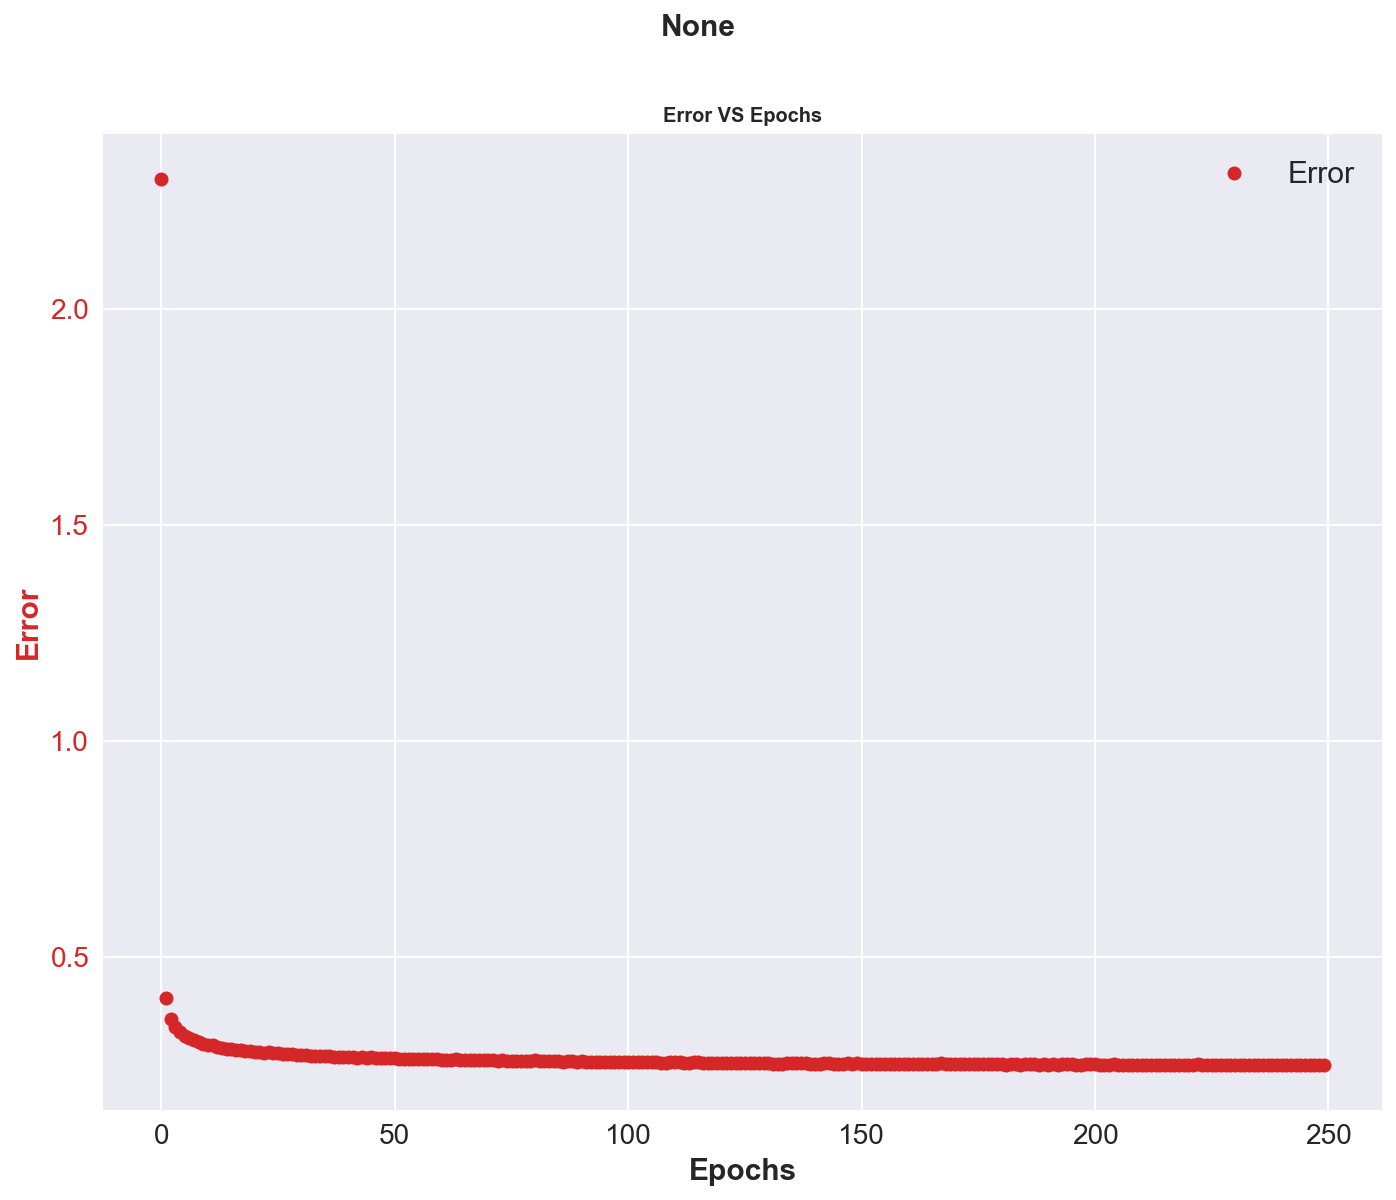

In [111]:
#MNIST Dataset: training
LogisReg = SoftmaxRegression(X_train, Y_train, X_val, Y_val, X_test, Y_test,USPS_x, USPS_y,
                             Lambda= 0.0001, LearningRate= 0.1, epoch= 250, BATCH_SIZE = 100)

#get predicted value for mnist dataset to plot confusion matrix
predict_Logis = LogisReg['predict']

print('Training Accuracy:' + str(LogisReg['TrainingAccuracy']))
print('Validation Accuracy:' + str(LogisReg['ValidationAccuracy']))

print('************Test Accuracy************')
print('Accuracy MNIST:'+ str(LogisReg['TestAccuracy']))
print('Accuracy USPS:' + str(LogisReg['USPS_Test']))

Errplot(Error=LogisReg['Error'], figname='error')

### confusion Matrix 1: Logistic Regression (softmax)

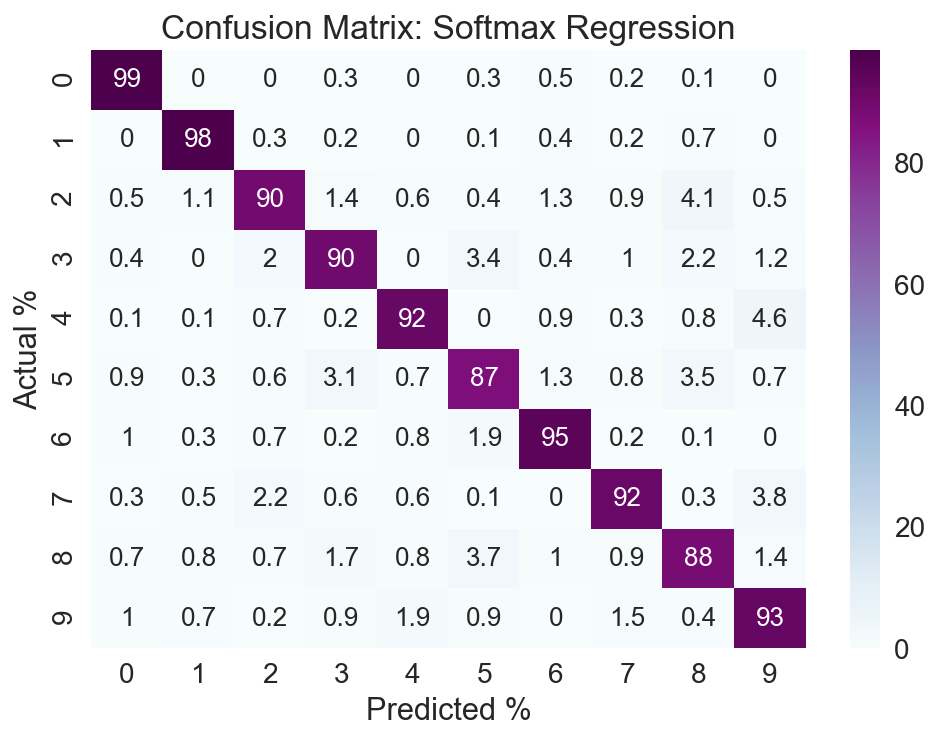

In [112]:
#plot confusion matrix on MNIST testing dataset
Conf_Matrix_LR = confusion_matrix(predict_Logis, Y_test)
plot_confMat(Conf_Matrix_LR, 'Confusion Matrix: Softmax Regression', 'conf_LR')

# Model 2. Neural Network

In [113]:
#define neural network model
def NeuNet(x_train, y_train, x_test, y_test, USPS_x, USPS_y, 
           hidden_neurons1, hidden_neurons2, batch_size, epochs):
    
    num_classes=10  # 10 classes for 0 to 9 digits
    image_vector_size=28*28  # image pixel size
    
    #MNIST Dataset for training and testing
    x_train = x_train.reshape(x_train.shape[0], image_vector_size)
    x_test = x_test.reshape(x_test.shape[0], image_vector_size)
    
    #one-hot encoding 
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    #USPS dataset for testing
    x_usps_test = USPS_x.reshape(USPS_x.shape[0], image_vector_size)
    y_usps_test = keras.utils.to_categorical(USPS_y, num_classes)

    image_size = 784 
    model = Sequential()
    # hidden layer 1 
    model.add(Dense(units=hidden_neurons1, activation='relu', input_shape=(image_size,)))
    #hidden layer 2 added
    model.add(Dense(units=hidden_neurons2, activation='relu'))
    #output laeyer
    model.add(Dense(units = num_classes, activation='softmax' ))

    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size, epochs, verbose=False,validation_split=.1)

    #output for MNIST dataset testing
    loss_mnist,accuracy_mnist = model.evaluate(x_test, y_test, verbose=False)
    
    #output for USPS data for testing 
    loss_usps,accuracy_usps = model.evaluate(x_usps_test, y_usps_test, verbose=False)
    
    #get predicted value
    predict_mnist = model.predict(x_test, batch_size=150)
    
    #return a dictionary
    return {'loss_mnist':loss_mnist, 'Accuracy_mnist':accuracy_mnist, 'predict':predict_mnist*100,
            'loss_usps':loss_usps, 'Accuracy_usps':accuracy_usps}


In [117]:
#run neural network model

NN = NeuNet(X_train, Y_train, X_test, Y_test, USPS_x, USPS_y, 
            hidden_neurons1=256, hidden_neurons2=32, batch_size=128, epochs=100)

#get predicted values for Mnist test data to plot confusion matrix
predict_NN = np.argmax(NN['predict'], axis = 1)

print('************Test Accuracy************\n')
print('Accuracy MNIST:' + str(NN['Accuracy_mnist']))
print('Accuracy USPS:' + str(NN['Accuracy_usps']))

************Test Accuracy************

Accuracy MNIST:0.966
Accuracy USPS:0.4060203010075998


### confusion matrix 2: Neural Network

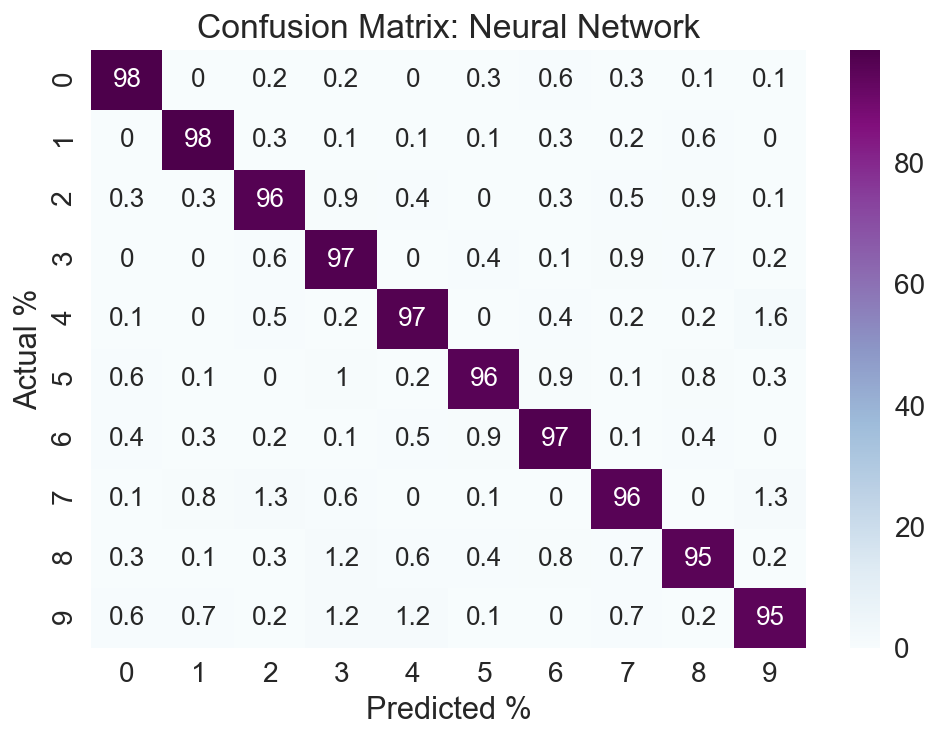

In [118]:
#plot confusion matrix on MNIST testing dataset
Conf_Matrix_NN = confusion_matrix(predict_NN, Y_test)
plot_confMat(Conf_Matrix_NN, 'Confusion Matrix: Neural Network', 'conf_NN')

# Model 3: Support Vector Machine (SVM)

In [ ]:
# SVM & RandomForest
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_mldata

# SVM model implemented using sklearn package
#define model
def svm(x_train, y_train, x_test, y_test, USPS_x, USPS_y, ker, deg, c, g ):
    classifier1 = SVC(kernel=str(ker), degree = deg, C = c, gamma = g);
    classifier1.fit(x_train, y_train)
    
    #get predited output from MNIST test data
    predict = classifier1.predict(x_test)
    
    #get accuracy from mnist test data and usps data
    accuracy_mnist = classifier1.score(x_test, y_test)
    accuracy_usps = classifier1.score(USPS_x, USPS_y)
    return accuracy_mnist, accuracy_usps, predict

#train model on MNIST and test on MNIST testing and USPS data. 
#ker = kernel, deg = degree for poly, g = gamma
accuracy_svm, accuracy_usps_svm, predict_svm = svm(X_train, Y_train,  X_test, Y_test, USPS_x, USPS_y,
                                ker = 'poly', deg = 3, c = 2, g = 0.05)

print('************SVM Test Accuracy************\n')
print('Accuracy MNIST:' + str(accuracy_svm))
print('Accuracy USPS:' + str(accuracy_usps_svm))

### Confusion Matrix 3: SVM

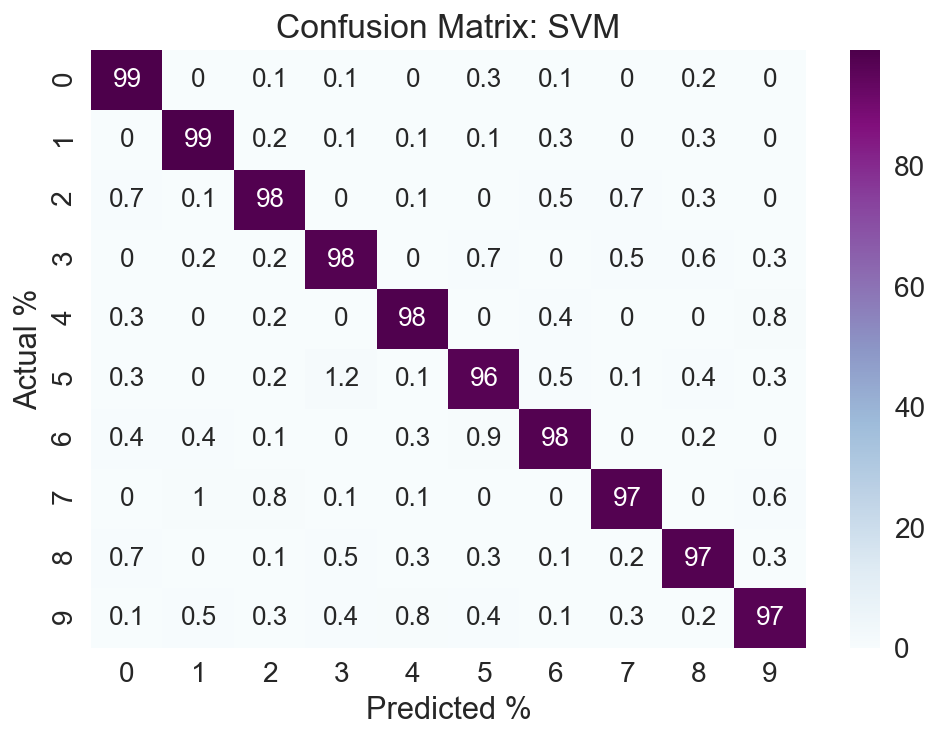

In [61]:
#plot confusion matrix on MNIST testing dataset
Conf_Matrix_svm = confusion_matrix(predict_svm, Y_test)
plot_confMat(Conf_Matrix_svm, 'Confusion Matrix: SVM', 'conf_svm')

# Model 4: Random Forest Classifier

In [50]:
#define random forest classifier. 
#sklearn method RandomForestClassifier is used 

def rf(x_train, y_train, x_test, y_test, usps_x, usps_y, n_estimators, criterion, max_depth):
    classifier2 = RandomForestClassifier(n_estimators, criterion, max_depth);
    classifier2.fit(x_train, y_train)
    
    #get accuracy from mnist testing set
    accuracy_mnist = classifier2.score(x_test, y_test)
    #get accuracy from usps dataset
    accuracy_usps  = classifier2.score(usps_x, usps_y)
    #get predited output value of mnist test data
    predict = classifier2.predict(x_test)
    
    #return accuracies and predicted value
    return accuracy_mnist, accuracy_usps, predict


In [71]:
# run random forest model 
accuracy_rf, accuracy_usps_rf, predict_rf = rf(X_train, Y_train, X_test, Y_test, USPS_x, USPS_y,
                                               n_estimators=100, criterion = 'entropy', max_depth=50)

print('************Random Forest Test Accuracy************\n')
print('Accuracy MNIST:' + str(accuracy_rf))
print('Accuracy USPS:' + str(accuracy_usps_rf))

************Random Forest Test Accuracy************

Accuracy MNIST:0.966
Accuracy USPS:0.38451922596129806


In [ ]:
#change hyperparameter max_depth
#accuracy_mnist = []
# accuracy_usps = []
# max_depth = [1, 2, 3, 4, 5, 10, 15, 20]
# for i in max_depth:
#     accuracy_rf, accuracy_usps_rf, predict_rf = rf(X_train, Y_train, X_test, Y_test, USPS_x, USPS_y,
#                                                n_estimators=50, criterion = 'gini', max_depth=i)
#     m.append(accuracy_rf)
#     u.append(accuracy_usps_rf)
# print(accuracy_mnist)
# print(accuracy_usps)

### Confusion Matrix 4: Random Forest

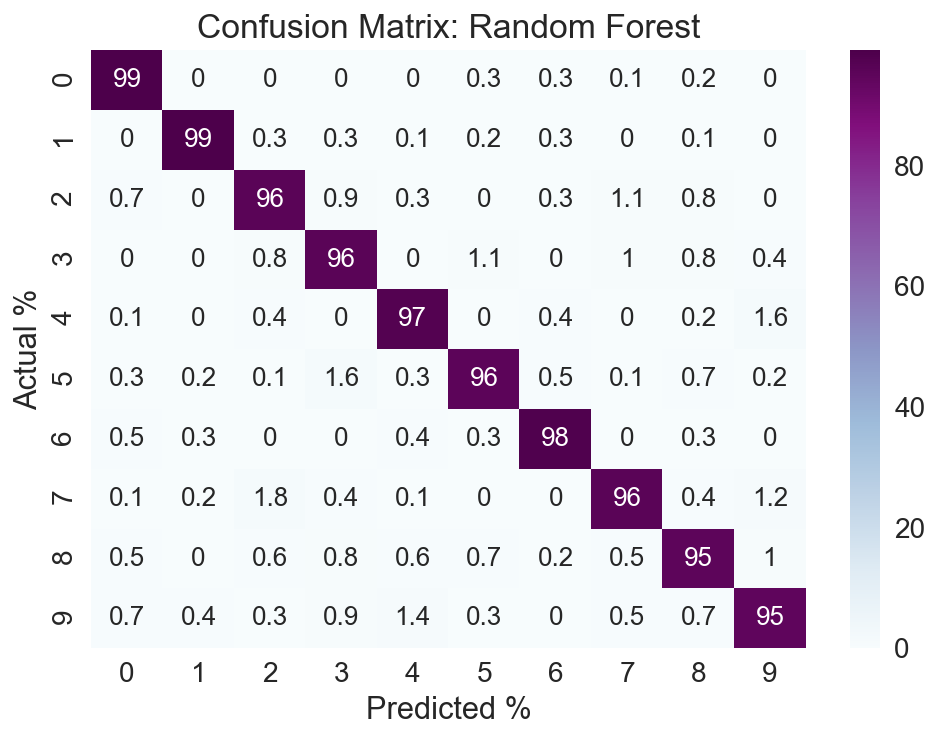

In [65]:
#plot confusion matrix on MNIST testing dataset
Conf_Matrix_rf = confusion_matrix(predict_rf, Y_test)
plot_confMat(Conf_Matrix_rf, 'Confusion Matrix: Random Forest', 'conf_rf')

# Bagging: Bootstrap Aggregating

In [84]:
from random import randrange

#create a subsample for bagging by randomly picking data with replacement using randrange method
def subsample(x, y, ratio): # ratio: size of subsample compared to original training data
    sample_data = []  
    sample_target = []
    n_sample = round(len(x) * ratio)
    while len(sample_data) < n_sample:  
        index = randrange(len(x))   # pick random index of the samples (row) using randrange
        sample_data.append(x[index])  # append randomly picked data to the sub sample 
        sample_target.append(y[index])
    return sample_data, sample_target # return subsamples data and target

### create subsets of the traning set: randomly picked with replacement

In [85]:
import itertools

#create five subsets of training samples and target sets for bagging
samples = []
target = []

#get 5 different subsamples
for i  in range(5):
    sample, t = subsample(X_train, Y_train, 0.6)  # get 60% of the dataset in each 5 subset of data
    samples.append(sample)
    target.append(t)

#subsets of training data for four models
sample_NN = np.array(samples[0])
sample_svm = np.array(samples[1])
sample_RF = np.array(samples[2])
sample_Logis1 = np.array(samples[3]) # softmax regression model 1 training for bagging
sample_Logis2 = np.array(samples[4])  # softmax regression model 2 training for bagging

#create subsets of target data for four models 
target_NN = np.array(target[0])
target_svm = np.array(target[1])
target_RF = np.array(target[2])
target_Logis1 = np.array(target[3])
target_Logis2 = np.array(target[4])

print(sample_NN.shape)
print(target_NN.shape)
print(sample_svm.shape)
print(target_svm.shape)

(30000, 784)
(30000,)
(30000, 784)
(30000,)


#### Bagging: subsamples of training data trained on four classification models

In [94]:
#1. Neural Network
B_NN = NeuNet(sample_NN, target_NN, X_test, Y_test, USPS_x, USPS_y, 
            hidden_neurons1=256, hidden_neurons2=32, batch_size=128, epochs=250)

B_predict_NN = np.argmax(NN['predict'], axis = 1) #prediction on test

In [95]:
#2. SVM     #prediction on test
B_accuracy_svm, B_accuracy_usps_svm, B_predict_svm = svm(sample_svm, target_svm, X_test, Y_test, USPS_x, USPS_y,
                                ker = 'poly', deg = 3, c = 2, g = 0.05)

In [96]:
#3 Random Forest    #prediction on test
B_accuracy_rf, B_accuracy_usps_rf, B_predict_rf = rf(sample_RF, target_RF, X_test, Y_test, USPS_x, USPS_y,
                             n_estimators=100, criterion = 'gini', max_depth=50)

In [97]:
#4. Multiclass Logistic Regression
B_LogisReg1 = SoftmaxRegression(sample_Logis1, target_Logis1, X_val, Y_val, X_test, Y_test,USPS_x, USPS_y,
                             Lambda= 0.0001, LearningRate= 0.1, epoch= 200, BATCH_SIZE = 128)

B_predict_Logis1 = B_LogisReg1['predict']


#5. Logistic Regression with different subsample
B_LogisReg2 = SoftmaxRegression(sample_Logis2, target_Logis2, X_val, Y_val, X_test, Y_test,USPS_x, USPS_y,
                             Lambda= 0.0001, LearningRate= 0.1, epoch= 200, BATCH_SIZE = 128)

B_predict_Logis2 = B_LogisReg2['predict']

In [98]:
print('*****1. Neural Network*******')
print('Accuracy:'+ str(B_NN['Accuracy_mnist']))
print('\n')
print('----------------------------')
print('\n')
print('***********2. SVM************')
print('Accuracy:' +str(B_accuracy_svm))
print('\n')
print('----------------------------')
print('\n')
print('*******3. Ramdom Forest*******')
print('Accuracy:' + str(B_accuracy_rf))
print('\n')
print('****4. Logistic Regression1****')
print('Training Accuracy'+str(B_LogisReg1['TrainingAccuracy']))
print('validation Accuracy'+str(B_LogisReg1['ValidationAccuracy']))
print('Testing Accuracy' +str(B_LogisReg1['TestAccuracy']))
print('\n')
print('****5. Logistic Regression2****')
print('Training Accuracy'+str(B_LogisReg2['TrainingAccuracy']))
print('validation Accuracy'+str(B_LogisReg2['ValidationAccuracy']))
print('Testing Accuracy' +str(B_LogisReg2['TestAccuracy']))

*****1. Neural Network*******
Accuracy:0.9699


----------------------------


***********2. SVM************
Accuracy:0.9698


----------------------------


*******3. Ramdom Forest*******
Accuracy:0.9614


****4. Logistic Regression1****
Training Accuracy0.942
validation Accuracy0.9196
Testing Accuracy0.9182
****5. Logistic Regression2****
Training Accuracy0.9368666666666666
validation Accuracy0.92
Testing Accuracy0.9181


## Majority Voting

In [99]:
#majority voting
from collections import Counter

#make an array out of the predicted values from the models
predictions = np.array([B_predict_NN, B_predict_svm, B_predict_rf, B_predict_Logis1, B_predict_Logis2])

#create a for majority voting results
maj_vote = []

#make a matrix out of the predicted results and occurance of each element of the same index is counted
for i in predictions.T:
    count = Counter(i).most_common() # counter method is used to count the occurance of each element
    #max vote or element with most occurance is stored as first index tuple in counter
    maj_vote.append(count[0][0])

print('-------Majority Vote Result predictions------')
print(len(maj_vote))

10000


## Bagging: Prediction

In [100]:
# compare majority vote prediction with the actual target vector and compute accuracy
acc = np.sum(maj_vote == Y_test)/len(Y_test)
print('*********Bagging***********')
print('Majority Vote: Prediction = '+ str(acc))

*********Bagging***********
Majority Vote: Prediction = 0.9678


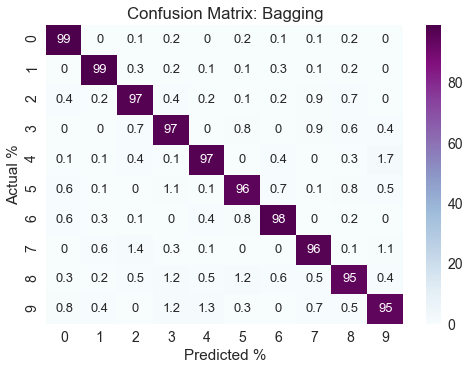

In [101]:
#construct a confusion matrix for prediction by bagging algorithm
Conf_Matrix = confusion_matrix(maj_vote, Y_test)
plot_confMat(Conf_Matrix, 'Confusion Matrix: Bagging', 'bagging')

# Boosting for random forest classifier

In [102]:
from sklearn.ensemble import AdaBoostClassifier
import itertools

In [82]:
#define the classifier to be boosted
clf1 = RandomForestClassifier(n_estimators=100, max_depth = 50);


In [103]:
#use sklearn package adaboostclassifier to implement boosting
boosting = AdaBoostClassifier(base_estimator=clf1, n_estimators=100, learning_rate=0.5)   
boosting.fit(X_train, Y_train)

#get accuracy from boosting on random forest
acc_boost = boosting.score(X_test, Y_test)

print(acc_boost)

0.9688


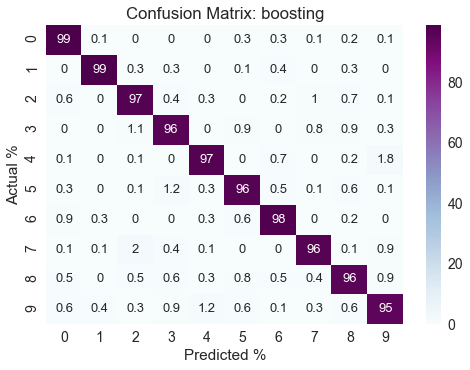

In [104]:
#get predicted values from boosting
prediciton_boosting = boosting.predict(X_test)

#construct confusion matrix out of boosting algorith
Conf_Matrix = confusion_matrix(prediciton_boosting, Y_test)
plot_confMat(Conf_Matrix, 'Confusion Matrix: boosting', 'boosting')

In [105]:
print('**********project 3 End*************')

**********project 3 End*************
